    # Introduction
A very important aspect of supervised and semi-supervised machine learning is the quality of the labels produced by human labelers. Unfortunately, humans are not perfect and in some cases may even maliciously label things incorrectly. In this assignment, you will evaluate the impact of incorrect labels on a number of different classifiers.

We have provided a number of code snippets you can use during this assignment. Feel free to modify them or replace them.


## Dataset
The dataset you will be using is the [Adult Income dataset](https://archive.ics.uci.edu/ml/datasets/Adult). This dataset was created by Ronny Kohavi and Barry Becker and was used to predict whether a person's income is more/less than 50k USD based on census data.

### Data preprocessing
Start by loading and preprocessing the data. Remove NaN values, convert strings to categorical variables and encode the target variable (the string <=50K, >50K in column index 14).

In [1]:
import pandas as pd
import numpy as np
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sympy.solvers.ode.single import Bernoulli

In [2]:
# This can be used to load the dataset
data = pd.read_csv("adult.csv", na_values='?')
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

df = data.dropna().copy()

df['salary'] = df['salary'].astype(str).apply(lambda x: 1 if '>' in x else 0)

categorical_cols = [
    'marital-status', 'workclass', 'occupation',
    'relationship', 'race', 'native-country'
]
# Capital loss and capital gain represent essentially the exact same information
# Capital delta can represent both at the same time without increasing dimensionality
df['capital-delta'] = df['capital-gain'] - df['capital-loss']


# Education is the same as education-num if it were ordinally encoded.
# Capital loss/gain already encoded with capital delta
df.drop( columns=[ 'education', 'capital-gain', 'capital-loss' ], inplace=True)

categorical_transformer = OneHotEncoder(handle_unknown="ignore")
continuous_cols = [x for x in df.columns if x not in categorical_cols and x!='sex' and x != 'salary']
scaler = StandardScaler()
# Column transformer
binary_pipeline = Pipeline(
        [
            ( 'encode', OrdinalEncoder() ),
            ( 'transform', FunctionTransformer( lambda x: 2*x-1 ) )
        ]
    )

preprocessor = ColumnTransformer(
    transformers=[
        ("categorical", categorical_transformer, categorical_cols),
        ("continuous", scaler, continuous_cols),
        ("binary", binary_pipeline, ['sex'])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)



In [4]:
def identify_outliers( x, columns ):
    for column in columns:
        x_min, x_max = x[column].min(), x[column].max()
        mean, std = x[column].mean(), x[column].std()

        #print( f"Min: {x_min}\tMax: {x_max}" )
        #print( f"Mean: {mean}\tSTD: {std}" )

        lows = x[column] <= mean - 1.96*std
        highs = x[column] >= mean + 1.96*std
        lows, highs = x[lows], x[highs]

        print( f"{column.capitalize()}:\tLow:\t{lows.shape[0]}\t|\tHigh:\t{highs.shape[0]}" )

In [5]:
identify_outliers(df, continuous_cols)

Age:	Low:	0	|	High:	1561
Fnlwgt:	Low:	0	|	High:	1826
Education-num:	Low:	2242	|	High:	544
Hours-per-week:	Low:	1869	|	High:	1527
Capital-delta:	Low:	0	|	High:	365


In [6]:

from scipy.stats import chi2_contingency


def cramers_V( X, cols ):
    cramer_matrix = pd.DataFrame( index=cols, columns=cols, dtype=float )

    for col1 in cols:
        for col2 in cols:
            conf_mat = pd.crosstab( X[col1], X[col2] )
            chi_sq = chi2_contingency( conf_mat )[0]
            n = conf_mat.sum().sum()
            V = chi_sq/(n*(min(conf_mat.shape)-1))
            cramer_matrix.loc[col1,col2] = float( np.sqrt( V ) )

    return cramer_matrix


### Data classification
Choose at least 4 different classifiers and evaluate their performance in predicting the target variable. 

#### Preprocessing
Think about how you are going to encode the categorical variables, normalization, whether you want to use all of the features, feature dimensionality reduction, etc. Justify your choices 

A good method to apply preprocessing steps is using a Pipeline. Read more about this [here](https://machinelearningmastery.com/columntransformer-for-numerical-and-categorical-data/) and [here](https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf). 

<!-- #### Data visualization
Calculate the correlation between different features, including the target variable. Visualize the correlations in a heatmap. A good example of how to do this can be found [here](https://towardsdatascience.com/better-heatmaps-and-correlation-matrix-plots-in-python-41445d0f2bec). 

Select a features you think will be an important predictor of the target variable and one which is not important. Explain your answers. -->

#### Evaluation
Use a validation technique from the previous lecture to evaluate the performance of the model. Explain and justify which metrics you used to compare the different models. 

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# ----------------------------
# Define your preprocessing steps
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

binary_pipeline = Pipeline([
    ('encode', OrdinalEncoder()),
    ('transform', FunctionTransformer(lambda x: 2*x-1, feature_names_out='one-to-one'))
])

steps = [
    ("categorical", categorical_transformer, categorical_cols),
    ("continuous", scaler, continuous_cols),
    ("binary", binary_pipeline, ['sex'])
]

preprocessor = ColumnTransformer(
    transformers=steps,
    remainder="passthrough",
    verbose_feature_names_out=False
)

# ----------------------------
# Prepare data
target_col = 'salary'
data = df.copy()
dataX = data.drop(columns=[target_col])
dataY = data[target_col]

X_train, X_test, Y_train, Y_test = train_test_split(
    dataX, dataY, test_size=0.2, stratify=dataY
)

# ----------------------------
# Visualize correlations
def cramers_V(X, cols):
    """Compute Cramér's V between categorical columns."""
    from scipy.stats import chi2_contingency
    import numpy as np
    cramer_matrix = pd.DataFrame(index=cols, columns=cols, dtype=float)
    for col1 in cols:
        for col2 in cols:
            conf_mat = pd.crosstab(X[col1], X[col2])
            chi_sq = chi2_contingency(conf_mat)[0]
            n = conf_mat.sum().sum()
            V = chi_sq / (n * (min(conf_mat.shape) - 1))
            cramer_matrix.loc[col1, col2] = np.sqrt(V)
    return cramer_matrix

def visualize(data, preprocessor, categorical_cols=None):
    """Visualize correlations including numeric and categorical (Cramér's V)."""
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Numeric correlation
    corr_numeric = X.corr(numeric_only=True)
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_numeric, cmap="coolwarm", center=0)
    plt.title("Pearson Correlation Matrix Including Target Variable")
    plt.show()

    # Categorical correlation
    if categorical_cols is not None and len(categorical_cols) > 0:
        cat_cols = categorical_cols.copy()
        if target_col not in cat_cols:
            cat_cols.append(target_col)
        cramer_matrix = cramers_V(data, cat_cols)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cramer_matrix.astype(float), cmap="coolwarm", center=0)
        plt.title("Cramér's V Matrix for Categorical Features")
        plt.show()
    else:
        cramer_matrix = None

    return corr_numeric, cramer_matrix

# ----------------------------
# Apply your model
def apply_model(model, X, y):
    pipeline = Pipeline(steps=[('t', preprocessor), ('m', model)])

    # Fit on full training data
    pipeline.fit(X, y)

    # Training predictions and metrics
    y_pred_train = pipeline.predict(X)
    train_acc = accuracy_score(y, y_pred_train)
    train_precision = precision_score(y, y_pred_train, average='weighted', zero_division=0)
    train_recall = recall_score(y, y_pred_train, average='weighted', zero_division=0)
    train_f1 = f1_score(y, y_pred_train, average='weighted', zero_division=0)

    print("Training Performance:")
    print(f"  Accuracy : {train_acc:.4f}")
    print(f"  Precision: {train_precision:.4f}")
    print(f"  Recall   : {train_recall:.4f}")
    print(f"  F1 Score : {train_f1:.4f}")

    # Evaluate on test set
    return evaluate_model(X_test, Y_test, pipeline)

# ----------------------------
# Evaluate model
def evaluate_model(X, y, pipeline):
    y_pred = pipeline.predict(X)

    acc = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y, y_pred, average='weighted', zero_division=0)

    results = {
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    print("Test Performance:")
    print(f"  Accuracy : {acc:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall   : {recall:.4f}")
    print(f"  F1 Score : {f1:.4f}")

    return results


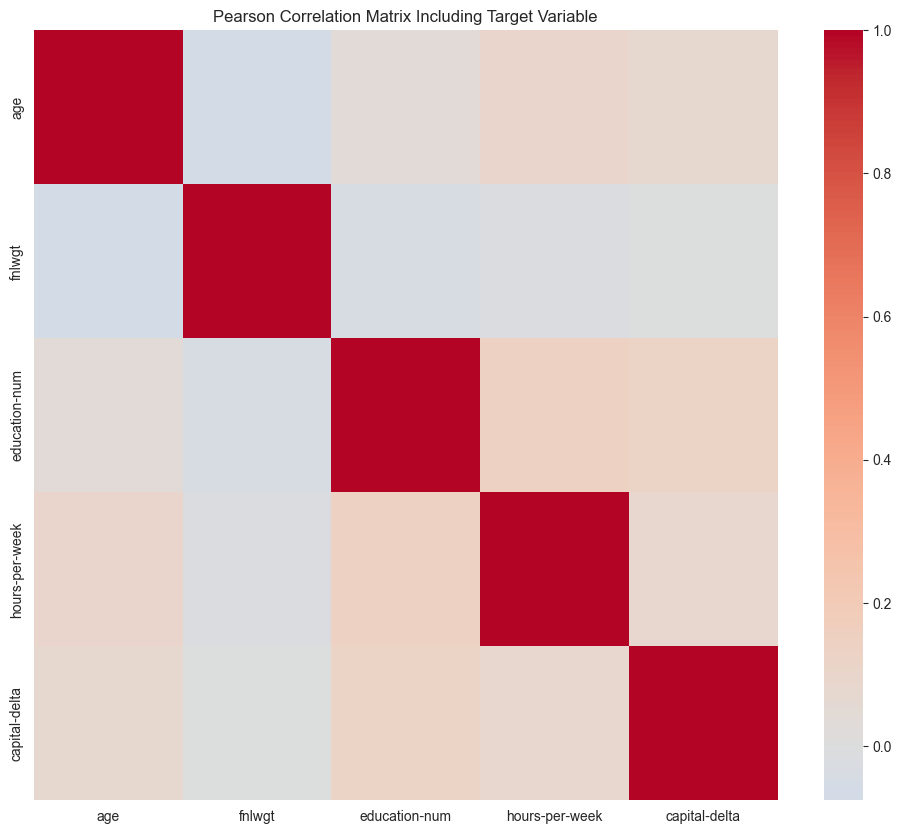

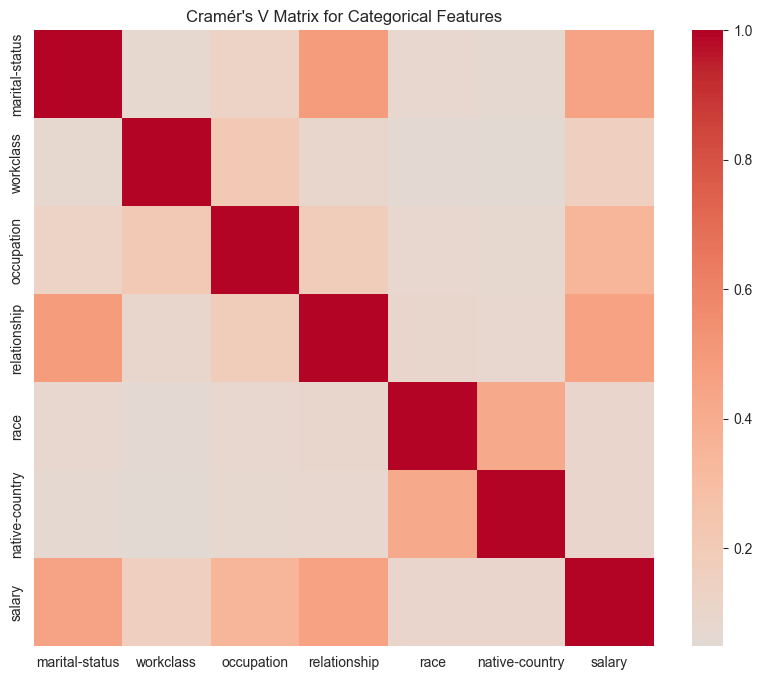

(                     age    fnlwgt  education-num  hours-per-week  \
 age             1.000000 -0.075792       0.037623        0.101992   
 fnlwgt         -0.075792  1.000000      -0.041993       -0.018679   
 education-num   0.037623 -0.041993       1.000000        0.146206   
 hours-per-week  0.101992 -0.018679       0.146206        1.000000   
 capital-delta   0.076239 -0.003864       0.122110        0.080700   
 
                 capital-delta  
 age                  0.076239  
 fnlwgt              -0.003864  
 education-num        0.122110  
 hours-per-week       0.080700  
 capital-delta        1.000000  ,
                 marital-status  workclass  occupation  relationship      race  \
 marital-status        1.000000   0.077422    0.130407      0.487134  0.081836   
 workclass             0.077422   1.000000    0.216938      0.088658  0.059641   
 occupation            0.130407   0.216938    1.000000      0.176946  0.081859   
 relationship          0.487134   0.088658    0.176

In [8]:
visualize(df, preprocessor, categorical_cols)

In [9]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models = [LogisticRegression(), BernoulliNB(), SVC(), GradientBoostingClassifier(random_state=42)]
dataY = dataY.astype(int)
for m in models:
    print(f'Model {m.__class__.__name__}:')
    apply_model(m, X_train, Y_train)

Model LogisticRegression:
Training Performance:
  Accuracy : 0.8433
  Precision: 0.8366
  Recall   : 0.8433
  F1 Score : 0.8378
Test Performance:
  Accuracy : 0.8450
  Precision: 0.8385
  Recall   : 0.8450
  F1 Score : 0.8397
Model BernoulliNB:
Training Performance:
  Accuracy : 0.7597
  Precision: 0.8154
  Recall   : 0.7597
  F1 Score : 0.7737
Test Performance:
  Accuracy : 0.7645
  Precision: 0.8199
  Recall   : 0.7645
  F1 Score : 0.7782
Model SVC:
Training Performance:
  Accuracy : 0.8567
  Precision: 0.8509
  Recall   : 0.8567
  F1 Score : 0.8507
Test Performance:
  Accuracy : 0.8551
  Precision: 0.8491
  Recall   : 0.8551
  F1 Score : 0.8486
Model GradientBoostingClassifier:
Training Performance:
  Accuracy : 0.8650
  Precision: 0.8602
  Recall   : 0.8650
  F1 Score : 0.8585
Test Performance:
  Accuracy : 0.8641
  Precision: 0.8591
  Recall   : 0.8641
  F1 Score : 0.8582


### Label perturbation
To evaluate the impact of faulty labels in a dataset, we will introduce some errors in the labels of our data.


#### Preparation
Start by creating a method which alters a dataset by selecting a percentage of rows randomly and swaps labels from a 0->1 and 1->0. 


In [10]:
"""Given a label vector, create a new copy where a random fraction of the labels have been flipped."""
def pertubate(y, fraction: float) -> np.ndarray:
    y_copy = y.copy()
    n_flip = int(len(y) * fraction)

    # Randomly select indices to flip
    flip_indices = np.random.choice(len(y), size=n_flip, replace=False)
    # print(y_copy.index())
    # Flip the labels (binary case)
    y_copy.iloc[flip_indices] = 1 ^ y_copy.iloc[flip_indices]

    return y_copy

#### Analysis
Create a number of new datasets with perturbed labels, for fractions ranging from `0` to `0.5` in increments of `0.1`.

Perform the same experiment you did before, which compared the performances of different models except with the new datasets. Repeat your experiment at least 5x for each model and perturbation level and calculate the mean and variance of the scores. Visualize the change in score for different perturbation levels for all of the models in a single plot. 

State your observations. Is there a change in the performance of the models? Are there some classifiers which are impacted more/less than other classifiers and why is this the case?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score


def apply_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return {"Accuracy": accuracy_score(y_test, y_pred)}

fractions = np.arange(0.0, 0.6, 0.1)  # 0, 0.1, ..., 0.5
n_repeats = 5

X = data.drop(columns=[target_col])
y = data[target_col]

pert_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "BernoulliNB": BernoulliNB(),
    "SVC": SVC(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

results = {model_name: [] for model_name in pert_models.keys()}

for frac in fractions:
    frac_results = {model_name: [] for model_name in pert_models.keys()}
    print(f"Fraction: {frac:.1f}")

    for repeat in range(n_repeats):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, stratify=y, random_state=repeat
        )

        for model_name, model in pert_models.items():
            pert_y_train = pertubate(y_train, frac)
            score = apply_model(model, X_train, pert_y_train, X_test, y_test)
            frac_results[model_name].append(score["Accuracy"])

    # Store mean and variance
    for model_name in pert_models.keys():
        mean_score = np.mean(frac_results[model_name])
        var_score = np.var(frac_results[model_name])
        results[model_name].append((mean_score, var_score))



Fraction: 0.1
Training Performance:
  Accuracy : 0.7736
  Precision: 0.7619
  Recall   : 0.7736
  F1 Score : 0.7566
Test Performance:
  Accuracy : 0.8462
  Precision: 0.8391
  Recall   : 0.8462
  F1 Score : 0.8389
Training Performance:
  Accuracy : 0.7718
  Precision: 0.7601
  Recall   : 0.7718
  F1 Score : 0.7544
Test Performance:
  Accuracy : 0.8404
  Precision: 0.8328
  Recall   : 0.8404
  F1 Score : 0.8332
Training Performance:
  Accuracy : 0.7724
  Precision: 0.7603
  Recall   : 0.7724
  F1 Score : 0.7550
Test Performance:
  Accuracy : 0.8398
  Precision: 0.8320
  Recall   : 0.8398
  F1 Score : 0.8320
Training Performance:
  Accuracy : 0.7752
  Precision: 0.7638
  Recall   : 0.7752
  F1 Score : 0.7586
Test Performance:
  Accuracy : 0.8441
  Precision: 0.8367
  Recall   : 0.8441
  F1 Score : 0.8364
Training Performance:
  Accuracy : 0.7716
  Precision: 0.7600
  Recall   : 0.7716
  F1 Score : 0.7549
Test Performance:
  Accuracy : 0.8388
  Precision: 0.8309
  Recall   : 0.8388
  F1 S

In [ ]:
# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
for model_name, scores in results.items():
    means = [m for m, v in scores]
    vars_ = [v for m, v in scores]
    plt.errorbar(fractions, means, yerr=np.sqrt(vars_), label=model_name, capsize=3, marker="o")

plt.xlabel("Fraction of Labels Flipped")
plt.ylabel("Accuracy")
plt.title("Classifier Robustness under Label Noise")
plt.legend()
plt.show()


In [91]:
results

{'Logistic Regression': [(np.float64(0.8461028192371476), np.float64(0.0)),
  (np.float64(0.8422996130458819), np.float64(1.195912214616385e-06)),
  (np.float64(0.8386511885019348), np.float64(1.0071869019253264e-07)),
  (np.float64(0.8362631288004423), np.float64(2.967778880916366e-06)),
  (np.float64(0.8266666666666668), np.float64(1.6762328031851102e-05)),
  (np.float64(0.4953454947484798), np.float64(0.0006013912991397047))],
 'BernoulliNB': [(np.float64(0.7618573797678275), np.float64(0.0)),
  (np.float64(0.7553565505804313), np.float64(5.348846945177028e-07)),
  (np.float64(0.751354339414041), np.float64(3.6913888881248546e-06)),
  (np.float64(0.7476174682144832), np.float64(1.0186277628502617e-05)),
  (np.float64(0.7454726368159205), np.float64(1.7280589253230188e-05)),
  (np.float64(0.4858374792703152), np.float64(0.005009687023392955))],
 'Decision Tree': [(np.float64(0.851299060254284),
   np.float64(1.232595164407831e-32)),
  (np.float64(0.8495522388059701), np.float64(7.500

Observations + explanations: max. 400 words

#### Discussion

1)  Discuss how you could reduce the impact of wrongly labeled data or correct wrong labels. <br />
    max. 400 words



    Authors: Youri Arkesteijn, Tim van der Horst and Kevin Chong.


## Machine Learning Workflow

From part 1, you will have gone through the entire machine learning workflow which are they following steps:

1) Data Loading
2) Data Pre-processing
3) Machine Learning Model Training
4) Machine Learning Model Testing

You can see these tasks are very sequential, and need to be done in a serial fashion. 

As a small perturbation in the actions performed in each of the steps may have a detrimental knock-on effect in the task that comes afterwards.

In the final part of Part 1, you will have experienced the effects of performing perturbations to the machine learning model training aspect and the reaction of the machine learning model testing section.

## Part 2 Data Discovery

You will be given a set of datasets and you are tasked to perform data discovery on the data sets.

<b>The datasets are provided in the group lockers on brightspace. Let me know if you are having trouble accessing the datasets</b>

The process is to have the goal of finding datasets that are related to each other, finding relationships between the datasets.

The relationships that we are primarily working with are Join and Union relationships.

So please implement two methods for allowing us to find those pesky Join and Union relationships.

Try to do this with the datasets as is and no processing.



In [1]:
## Cleaning data, scrubbing, washing, mopping
import csv


import pandas as pd
import csv
from pathlib import Path
import statistics

def try_sniffer(filepath, sample_size=8192, delimiters=",;\t|:"):
    """Try csv.Sniffer on a bigger sample; return delimiter or None."""
    with open(filepath, "r", encoding="utf-8", errors="replace") as f:
        sample = f.read(sample_size)
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters)
        return dialect.delimiter
    except csv.Error:
        return None

def detect_delimiter_counts(filepath, candidates=["_",",",";","\t","|",":"], n_lines=20):

    lines = []
    with open(filepath, "r", encoding="utf-8", errors="replace") as f:
        for _ in range(n_lines):
            line = f.readline()
            lines.append(line)
    if not lines:
        return None

    best = None
    best_score = 0.0
    for d in candidates:
        counts = [line.count(d) for line in lines]
        nonzero = sum(1 for c in counts if c > 0)
        if nonzero == 0:
            continue
        # score = median count * fraction of lines that contain the delimiter
        med = statistics.median([c for c in counts if c > 0])
        score = med * (nonzero / len(lines))
        if score > best_score:
            best_score = score
            best = d
    return best

def read_csv_flexible(filepath, verbose=True):
    p = Path(filepath)
    if verbose:
        print(f"Reading {p} ...")


    # 1) Heuristic by counting delimiter occurrences
    delim = detect_delimiter_counts(p)
    if delim:
        try:
            df = pd.read_csv(p, sep=delim, engine="python", on_bad_lines="skip")
            if verbose:
                print(f" -> Heuristic chose delimiter: {repr(delim)}")
            print(len(df.columns))
            return df
        except Exception as e:
            if verbose:
                print(f"    reading with heuristic delimiter failed: {e}")

    # 2) Last resort: read entire file as single column (one line per row)
    if verbose:
        print(" -> Falling back to reading file as single column (no delimiter).")
    df = pd.read_csv(p, sep="\n", header=None, names=["raw_line"], engine="python")
    return df

# Example: read all files in folder lake49 and keep the filename
from pathlib import Path
folder = Path("lake49")
dfs = {}
for f in folder.glob("*"):
    try:
        df = read_csv_flexible(f)
        dfs[str(f)]=df
    except Exception as e:
        print(f"Failed to read {f}: {e}")




dff = read_csv_flexible("lake49/table_0.csv")
print(len(dff.columns))


Reading lake49\table_0.csv ...
 -> Heuristic chose delimiter: '_'
49
Reading lake49\table_1.csv ...
 -> Heuristic chose delimiter: '\t'
49
Reading lake49\table_10.csv ...
 -> Heuristic chose delimiter: '_'
11
Reading lake49\table_11.csv ...
 -> Heuristic chose delimiter: '_'
13
Reading lake49\table_12.csv ...
 -> Heuristic chose delimiter: ','
41
Reading lake49\table_13.csv ...
 -> Heuristic chose delimiter: '\t'
41
Reading lake49\table_14.csv ...
 -> Heuristic chose delimiter: ','
19
Reading lake49\table_15.csv ...
 -> Heuristic chose delimiter: ','
15
Reading lake49\table_16.csv ...
 -> Heuristic chose delimiter: ','
23
Reading lake49\table_17.csv ...
 -> Heuristic chose delimiter: ','
21
Reading lake49\table_18.csv ...
 -> Heuristic chose delimiter: '_'
34
Reading lake49\table_19.csv ...
 -> Heuristic chose delimiter: ','
77
Reading lake49\table_2.csv ...
 -> Heuristic chose delimiter: '\t'
40
Reading lake49\table_3.csv ...
 -> Heuristic chose delimiter: ','
40
Reading lake49\table_

In [ ]:
import itertools
from collections import Counter
from difflib import SequenceMatcher
import unicodedata

def normalize_string(s: str) -> str:
    return unicodedata.normalize("NFKC", str(s)).lower().strip()

def table_signature(df: pd.DataFrame):
    sig = []
    for col in df.columns:
        if col.startswith("__"):  # skip metadata
            continue
        if pd.api.types.is_integer_dtype(df[col]):
            sig.append("int")
        elif pd.api.types.is_float_dtype(df[col]):
            sig.append("float")
        elif pd.api.types.is_datetime64_any_dtype(df[col]):
            sig.append("datetime")
        else:
            sig.append("string")
    return sig

def column_similarity(col1, col2, sample_size=10):
    vals1 = col1.dropna().astype(str).map(normalize_string)
    vals2 = col2.dropna().astype(str).map(normalize_string)

    if sample_size and len(vals1) > sample_size:
        vals1 = vals1.sample(sample_size, random_state=42)
    if sample_size and len(vals2) > sample_size:
        vals2 = vals2.sample(sample_size, random_state=42)

    set1, set2 = set(vals1), set(vals2)
    if not set1 or not set2:
        jaccard = 0.0
    else:
        jaccard = len(set1 & set2) / len(set1 | set2)

    name_sim = SequenceMatcher(None, normalize_string(col1.name), normalize_string(col2.name)).ratio()
    return 0.5 * jaccard + 0.5 * name_sim

# Union check
def unionable_by_type(sig1, sig2, threshold=0.8):
    if not sig1 or not sig2:
        return False
    counter1, counter2 = Counter(sig1), Counter(sig2)
    common_count = sum(min(counter1[t], counter2[t]) for t in counter1)
    overlap_ratio = common_count / max(len(sig1), len(sig2))
    return overlap_ratio >= threshold

# Relationship finder
def find_relationships(datasets, join_threshold=0.6, union_threshold=0.8):
    relationships = {"joins": [], "unions": []}

    for (i, (name1, df1)), (j, (name2, df2)) in itertools.combinations(enumerate(datasets.items()), 2):
        sig1 = table_signature(df1)
        sig2 = table_signature(df2)

        if unionable_by_type(sig1, sig2, threshold=union_threshold):
            print(f"[UNION] {name1} <--> {name2} (overlap ≥ {union_threshold})")
            relationships["unions"].append({
                "table1": name1,
                "table2": name2,
                "signature1": sig1,
                "signature2": sig2
            })

        joinable_cols = []
        found = False
        # takes a lot of time, so I only picked a few columns for speed, accuracy should
        # theoretically increase for a higher threshold and more columns
        for col1 in df1.columns[:10]:
            if found:
                break
            for col2 in df2.columns[:10]:
                if found:
                    break
                dtype1 = "string"
                dtype2 = "string"
                if pd.api.types.is_integer_dtype(df1[col1]): dtype1 = "int"
                elif pd.api.types.is_float_dtype(df1[col1]): dtype1 = "float"
                elif pd.api.types.is_datetime64_any_dtype(df1[col1]): dtype1 = "datetime"
                if pd.api.types.is_integer_dtype(df2[col2]): dtype2 = "int"
                elif pd.api.types.is_float_dtype(df2[col2]): dtype2 = "float"
                elif pd.api.types.is_datetime64_any_dtype(df2[col2]): dtype2 = "datetime"

                if dtype1 != dtype2:
                    continue

                sim = column_similarity(df1[col1], df2[col2])
                if sim >= join_threshold:
                    print(f"[JOIN] {name1}.{col1} <--> {name2}.{col2} (dtype={dtype1}, sim={sim:.2f})")
                    joinable_cols.append({
                        "col1": col1,
                        "col2": col2,
                        "similarity": sim,
                        "dtype": dtype1
                    })
                    found = True
                    break

        if joinable_cols:
            relationships["joins"].append({
                "table1": name1,
                "table2": name2,
                "joinable_columns": joinable_cols
            })

    return relationships

rels = find_relationships(dfs, join_threshold=0.6, union_threshold=0.8)

print("\n=== SUMMARY ===")
print("Unionable pairs:", len(rels["unions"]))
print("Joinable pairs:", len(rels["joins"]))


[UNION] lake49\table_0.csv <--> lake49\table_1.csv (overlap ≥ 0.8)
[JOIN] lake49\table_0.csv.UNB_MAJ_INJ_COUNT <--> lake49\table_1.csv.UNB_MAJ_INJ_COUNT (dtype=int, sim=1.00)
[JOIN] lake49\table_0.csv.PHANTOM_VEHICLE <--> lake49\table_10.csv.['SCALAR_ID📍' 'SCALAR_ID👍'] (dtype=int, sim=0.62)
[JOIN] lake49\table_0.csv.PHANTOM_VEHICLE <--> lake49\table_11.csv.['SCALAR_ID✨' 'SCALAR_ID👍'] (dtype=int, sim=0.62)
[JOIN] lake49\table_0.csv.UNB_MAJ_INJ_COUNT <--> lake49\table_16.csv.SURV_I (dtype=int, sim=0.63)
[JOIN] lake49\table_0.csv.UNB_MAJ_INJ_COUNT <--> lake49\table_17.csv.['SAMPLING_TECH🫂' 'SAMPLING_TECH👏'] (dtype=int, sim=0.63)
[JOIN] lake49\table_0.csv.UNB_MAJ_INJ_COUNT <--> lake49\table_2.csv.['AVG_VIS_PST1MT_QA💯' 'AVG_VIS_PST1MT_QA❌'] (dtype=int, sim=0.62)
[JOIN] lake49\table_0.csv.PHANTOM_VEHICLE <--> lake49\table_4.csv.['PERC_GREEN😩' 'PERC_GREEN😅'] (dtype=int, sim=0.61)
[JOIN] lake49\table_0.csv.DRIVER_COUNT_75PLUS <--> lake49\table_5.csv.['SURV_H💩' 'SURV_H🫂'] (dtype=int, sim=0.60)


You would have noticed that the data has some issues in them.
So perhaps those issues have been troublesome to deal with.

Please try to do some cleaning on the data.

After performing cleaning see if the results of the data discovery has changed?

Please try to explain this in your report, and try to match up the error with the observation.

In [ ]:
## Cleaning data, scrubbing, washing, mopping

def cleaningData(data):
    """Function should be able to clean the data
    Possible Input: List of datasets
    Output: List of cleaned datasets
    """

    pass

In [ ]:
# Lists to store results
unionable_pairs = []
joinable_pairs = []

# Iterate over all possible pairs of DataFrames
import itertools

for i, j in itertools.combinations(range(len(dfs)), 2):
    df1 = dfs[i]
    df2 = dfs[j]

    # Compute Josie relationship
    rels = josie_relationship(df1, df2, join_threshold=0.8)

    # Store unionable pairs
    if rels["unionable"]:
        unionable_pairs.append({
            "dataset1_index": i,
            "dataset2_index": j,
            "dataset1_columns": list(df1.columns),
            "dataset2_columns": list(df2.columns)
        })

    # Store joinable pairs (if any joinable columns exist)
    if rels["joinable_columns"]:
        joinable_pairs.append({
            "dataset1_index": i,
            "dataset2_index": j,
            "joinable_columns": rels["joinable_columns"]
        })

# --- Print results ---
print("Unionable table pairs:")
for u in unionable_pairs:
    print(u)

print("\nJoinable table pairs:")
for j in joinable_pairs:
    print(j)


## Discussions

1)  Different aspects of the data can effect the data discovery process. Write a short report on your findings. Such as which data quality issues had the largest effect on data discovery. Which data quality problem was repairable and how you choose to do the repair.

<!-- For the set of considerations that you have outlined for the choice of data discovery methods, choose one and identify under this new constraint, how would you identify and resolve this problem? -->

Max 400 words